In [1]:
#Imports
import os
import glob
import nilearn
import numpy as np
import pandas as pd
import nibabel as nib

from numpy import savetxt
from nilearn.input_data import NiftiLabelsMasker

# Output directories 

output_dir = '/project/4180000.19/multirat_stim/scratch/rabies_test/first_level/'
mask_rois_dir = os.path.join(output_dir, 'mask_ROIs/')
zscores_dir = os.path.join(output_dir, 'mask_ROIs/z_scores/')
residuals_dir = os.path.join(output_dir, 'mask_ROIs/residuals/')
effect_size_dir = os.path.join(output_dir, 'mask_ROIs/effect_size/')
effect_variance_dir = os.path.join(output_dir, 'mask_ROIs/effect_variance/')
real_timeseries_dir = os.path.join(output_dir, 'mask_ROIs/real_timeseries/')
predicted_timeseries_dir = os.path.join(output_dir, 'mask_ROIs/predicted_timeseries/')


if not os.path.exists(mask_rois_dir):
    os.makedirs(mask_rois_dir)
if not os.path.exists(zscores_dir):
    os.makedirs(zscores_dir)
if not os.path.exists(real_timeseries_dir):
    os.makedirs(real_timeseries_dir)
if not os.path.exists(residuals_dir):
    os.makedirs(residuals_dir)  
if not os.path.exists(effect_size_dir):
    os.makedirs(effect_size_dir)
if not os.path.exists(effect_variance_dir):
    os.makedirs(effect_variance_dir)
if not os.path.exists(predicted_timeseries_dir):
    os.makedirs(predicted_timeseries_dir)
    

/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [39]:
# - Init Variables 

    # Load atlas 
template_folder = '/groupshare/traaffneu/preclinimg/templates/'

template_path = template_folder+'/SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1/SIGMA_Rat_Anatomical_Imaging/SIGMA_Rat_Anatomical_InVivo_Template/SIGMA_InVivo_Brain_Template.nii'
atlas_img = nib.load(template_folder+'SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1/SIGMA_Rat_Brain_Atlases/SIGMA_Anatomical_Atlas/SIGMA_Anatomical_Brain_Atlas_rs.nii')
atlas_labels = template_folder+'/SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1/SIGMA_Rat_Brain_Atlases/SIGMA_Anatomical_Atlas/SIGMA_Anatomical_Brain_Atlas_Labels.txt'
atlas_mask = nib.load(template_folder+'SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1/SIGMA_Rat_Anatomical_Imaging/SIGMA_Rat_Anatomical_InVivo_Template/SIGMA_InVivo_Brain_Mask.nii')

    # Subject info 
metadata_stand ='/home/traaffneu/margal/code/multirat_se/script/table/metadata_stand.tsv'
df = pd.read_csv(metadata_stand, sep='\t')
df = df.loc[(df['exclude'] != 'yes')]

/groupshare/traaffneu/preclinimg/templates//SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1/SIGMA_Rat_Brain_Atlases/SIGMA_Anatomical_Atlas/SIGMA_Anatomical_Brain_Atlas_Labels.txt


In [ ]:
for index in range(0, 1):
    
    subj_num=str(df.iloc[index]['rat.sub'])[:-2]
    print('index:', index)
    print('subj:', subj_num)
    
    subj_img = glob.glob("/project/4180000.19/multirat_stim/rabies/preprocess/sub-0{}_ses-1/bold_datasink/commonspace_bold/*/*/*.nii.gz".format(subj_num, subj_num, subj_num))[0]
    
    
     # - Load result from GLM analysis - 
        
    first_level_output = '/project/4180000.19/multirat_stim/scratch/rabies_test/first_level'
    zscores = nib.load(first_level_output +'/z_score/z_score_sub-0{}_ses-1.nii.gz'.format(subj_num))
    residuals = nib.load(first_level_output +'/residuals/residuals_sub-0{}_ses-1.nii.gz'.format(subj_num))
    beta_estimates = nib.load(first_level_output + '/beta_estimates/beta_sub-0{}_ses-1.nii.gz'.format(subj_num))
    effect_var = nib.load(first_level_output + '/effect_var/effect_var_sub-0{}_ses-1.nii.gz'.format(subj_num))
    predicted_timeseries = nib.load(first_level_output +'/predicted_timeseries/predicted_timeseries_sub-0{}_ses-1.nii.gz'.format(subj_num))

    
    # - Extract signal from regions - 

    masker_stand = NiftiLabelsMasker(labels_img=atlas_img, mask_img=atlas_mask, standardize=True, detrend=True).fit(subj_img)
    masker = NiftiLabelsMasker(labels_img=atlas_img, mask_img=atlas_mask, resampling_target='labels').fit(subj_img)

    z_scores = masker.fit_transform(zscores)
    print("Done z_scores")
    residuals = masker.fit_transform(residuals)
    print("Done residuals")
    effect_size = masker.fit_transform(beta_estimates)
    print("Done effect_size")
    effect_var = masker.fit_transform(effect_var)
    print("Done effect_var")
    real_timeseries = masker_stand.fit_transform(subj_img)
    print("Done real_timeseries")
    predicted_timeseries = masker.fit_transform(predicted_timeseries)
    print("Done predicted_timeseries")
    
         # Save as .csv file
    savetxt(mask_zscores_dir+'zscores_sub-0{}_ses-1.csv'.format(subj_num), z_scores, delimiter=',')     
    savetxt(residuals_dir+'residuals_sub-0{}_ses-1.csv'.format(subj_num), residuals, delimiter=',')     
    savetxt(effect_size_dir+'effect_size_sub-0{}_ses-1.csv'.format(subj_num), effect_size, delimiter=',')    
    savetxt(effect_variance_dir+'effect_var_sub_sub-0{}_ses-1.csv'.format(subj_num), effect_var, delimiter=',')    
    savetxt(real_timeseries_dir+'real_timeseries_sub-0{}_ses-1.csv'.format(subj_num), real_timeseries, delimiter=',') 
    savetxt(predicted_timeseries_dir+'predicted_timeseries_sub-0{}_ses-1.csv'.format(subj_num), predicted_timeseries, delimiter=',')    



index: 0
subj: 200100
Done z_scores


In [80]:
# inverse_transform()

wanted = 551
new_mask = np.copy(atlas_img.get_fdata())
new_mask[new_mask != wanted] = 0

wanted_zone_img = nib.Nifti1Image(new_mask, affine=atlas_img.affine)
wanted_zone_masker = NiftiLabelsMasker(labels_img=atlas_img, mask_img=wanted_zone_img, resampling_target='labels')

z_scores_wanted_signals = wanted_zone_masker.fit_transform(zscores)
z_scores_wanted_img = wanted_zone_masker.inverse_transform(z_scores_wanted_signals)

max = np.max(z_scores[0])

test = np.copy(z_scores)
test[0][test[0] < max] = 0
inverse = masker.inverse_transform(test)

/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/scipy/ndimage/_measurements.py:802: RuntimeWarning: invalid value encountered in divide
  return sum / numpy.asanyarray(count).astype(numpy.float64)


[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.   

In [86]:
data_masker = NiftiLabelsMasker(labels_img=atlas_img, mask_img=atlas_mask)
zscores_data = zscores.get_fdata()
tmp = data_masker.fit_transform(zscores)
print(tmp)
tmp2 = data_masker.inverse_transform(tmp)
print(tmp2)
print(z_scores_wanted_img)
print(zscores_data.shape)
print(new_mask.shape)
zscores_data[new_mask != wanted] = 0
new_zscores_img = nib.Nifti1Image(zscores_data, affine=zscores.affine)


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_labels_masker.py:578: UserWarning: After resampling the label image to the data image, the following labels were removed: {1051.0, 861.0, 862.0, 991.0}. Label image only contains 229 labels (including background).
  warnings.warn("After resampling the label image to the "


[[-2.47426139e-01  3.22487739e-01  5.97991065e-02  2.36145018e-01
   2.01197924e-01  1.20551459e-01 -1.22416225e-01  8.30929475e-02
   1.26417143e-01  1.39838448e-01  2.81712044e-01  7.26221082e-03
   1.86596103e-01  3.84012063e-01  4.41809464e-01  3.53876899e-01
   2.52161753e-01  2.33117750e-01  2.62812095e-01  1.90444980e-01
   8.94744448e-01  3.60125484e-01  4.51075934e-02  2.14503409e-01
   5.58168856e-02  2.98451847e-01  4.82921067e-02  2.65482733e-01
   1.34842872e-01  1.12091006e-01  8.60638627e-01  6.75782822e-01
  -7.00977012e-01  9.52268347e-01  1.97490806e-01 -1.60678310e-01
   0.00000000e+00  0.00000000e+00  2.91984749e-01  4.38657709e-01
   3.01423684e-01  3.49768359e-01  0.00000000e+00  0.00000000e+00
   1.95527171e-01  9.37332907e-02  1.14631633e-01  5.96026711e-01
   1.37399349e-01 -2.94552866e-01  1.62137104e-01  3.22774648e-01
   5.24705490e-01  2.48288515e-01  1.00196020e+00  1.50230707e+00
   4.46520176e-01  5.93855483e-01  1.61487076e-01  1.33626847e-01
   7.00801

ValueError: mask_img and labels_img shapes must be identical.

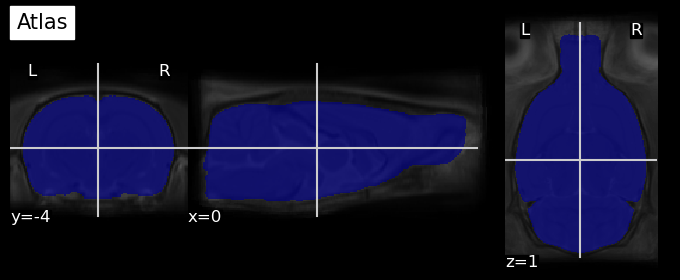

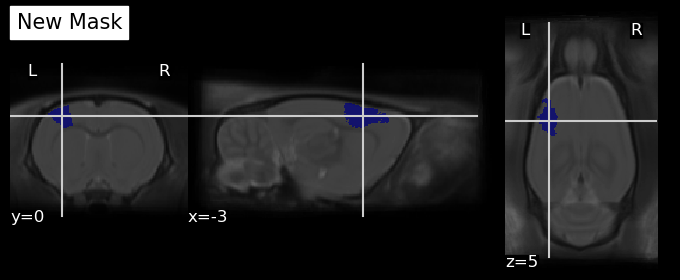

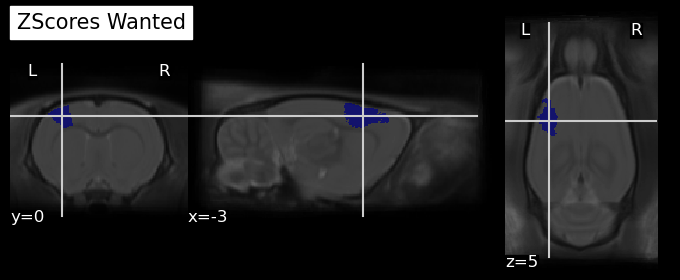

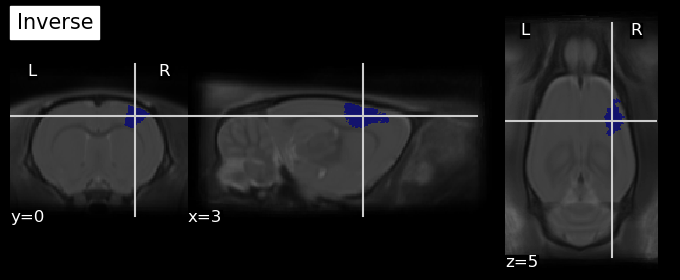

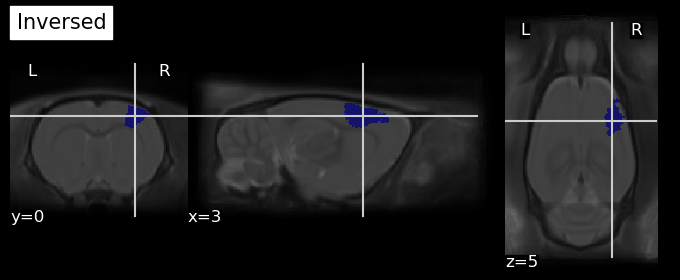

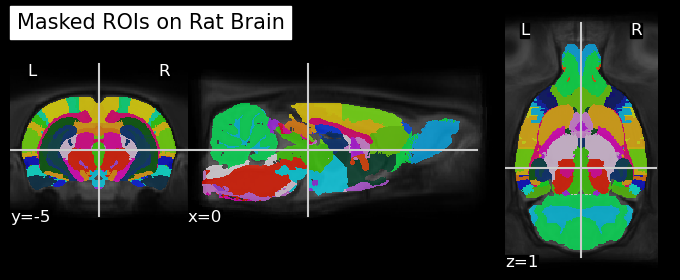

In [81]:
from nilearn import plotting


#report = masker.generate_report()
#report

plotting.plot_roi(atlas_mask, bg_img=template_path, title="Atlas")
plotting.plot_roi(nib.Nifti1Image(new_mask, affine=atlas_img.affine), bg_img=template_path, title="New Mask")
plotting.plot_roi(z_scores_wanted_img, bg_img=template_path, title="ZScores Wanted")
plotting.plot_roi(inverse, bg_img=template_path, title="Inverse")
plotting.plot_roi(inverse.slicer[:, :, :, 0], bg_img=template_path, title="Inversed")
plotting.plot_roi(masker.labels_img_, bg_img=template_path, title='Masked ROIs on Rat Brain') 

In [88]:
# -- Extract 1 or 2 ROI per scan --

atlas_labels = (template_folder+'SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1/SIGMA_Rat_Brain_Atlases/SIGMA_Anatomical_Atlas/SIGMA_Anatomical_Brain_Atlas_Labels.txt')
label_info = np.genfromtxt(atlas_labels, skip_header=10, delimiter='\t', dtype=str)


for scan in range(0, 1) :         
     
    subj_num=str(df.iloc[scan]['rat.sub'])[:-2]
    print('index:', scan)
    print('subj:', subj_num)
    
    #Load data  
    first_level_output = '/project/4180000.19/multirat_stim/scratch/rabies_test/first_level'
    zscores = pd.read_csv(zscores_dir +'zscores_sub-0{}_ses-1.csv'.format(subj_num))
    residuals = pd.read_csv(residuals_dir +'residuals_sub-0{}_ses-1.csv'.format(subj_num))
    effect_size = pd.read_csv(effect_size_dir +'effect_size_sub-0{}_ses-1.csv'.format(subj_num))
    effect_var = pd.read_csv(effect_variance_dir+'effect_var_sub_sub-0{}_ses-1.csv'.format(subj_num))
    real_timeseries = pd.read_csv(real_timeseries_dir+'real_timeseries_sub-0{}_ses-1.csv'.format(subj_num))
    predicted_timeseries = pd.read_csv(predicted_timeseries_dir+'predicted_timeseries_sub-0{}_ses-1.csv'.format(subj_num))
     

    #Find index of the ROI based on labels (specified in metadata)

    label_roi_1 = df.loc[scan]['roi.right']
    label_roi_2 = df.loc[scan]['roi.left']

    for row in label_info:                                   
        if row[-1].strip('"') == label_roi_1:         #access the last column of each row, remove quotes, compare
            label_idx_1 = int(row[0])                     #if match, assign the index found at row0 to label_index 
            print(label_idx_1)
            break
    else:
        raise ValueError("Label '{}' not found in the label file.".format(label_roi_1))
    

    for row in label_info:                                   
        if row[-1].strip('"') == label_roi_2:         #access the last column of each row, remove quotes, compare
            label_idx_2 = int(row[0])                     #if match, assign the index found at row0 to label_index 
            print(label_idx_2)
            break
    else:
        raise ValueError("Label '{}' not found in the label file.".format(label_roi_2))




index: 0
subj: 200100
552
551


<class 'numpy.ndarray'>


In [ ]:
# remove 5 first seconds of the dataset 300,400,500

import subprocess

for i in range (0, 31)
subprocess.run("cd /project/4180000.19/multirat_stim/test_3dresample/")
subprocess.run("3dresample -input yourscan.nii.gz[5..$] -prefix yourscan_minus_first_5_timepoints.nii.gz", shell=True)


In [98]:
    #Extract data from ROI

    from nilearn.maskers import NiftiMasker
    zscores = nib.load(first_level_output +'/z_score/z_score_sub-0{}_ses-1.nii.gz'.format(subj_num))

    roi_mask = np.logical_or(nilearn.image.get_data(atlas_img) == label_idx_1, nilearn.image.get_data(atlas_img) == label_idx_2)    # select ROIa based on the index
    roi_mask = roi_mask.astype(bool)

    roi_mask_img = nilearn.image.new_img_like(atlas_img, roi_mask)                       # create an mask image out of the roi selected
    masker = NiftiMasker(mask_img=roi_mask_img).fit(subj_img)  

    
    roi_timeseries = masker.fit_transform(zscores)
    print(len(roi_timeseries[0]))
    report = masker.generate_report()
    report

    # roi_residuals = masker.fit_transform(fmri_glm.residuals[0])    
    # roi_effect_size = masker.fit_transform(statistical_map['effect_size'])
    # roi_effect_variance = masker.fit_transform(statistical_map['effect_variance'])
    # roi_predicted_timeseries = masker.fit_transform(fmri_glm.predicted[0])


32748


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/maskers/nifti_masker.py:365: UserWarning: No image provided to fit in NiftiMasker. Setting image to mask for reporting.
  warnings.warn(msg)


Parameter,Value
detrend,False
dtype,None
high_pass,None
high_variance_confounds,False
low_pass,None
mask_args,None
mask_img,"<class 'nibabel.nifti1.Nifti1Image'> data shape (260, 342, 184) affine: [[ 0.09 0. 0. -11.60999966] [ 0. 0.09 0. -17.61750031] [ 0. 0. 0.09 -6.96597004] [ 0. 0. 0. 1. ]] metadata: <class 'nibabel.nifti1.Nifti1Header'> object, endian='<' sizeof_hdr : 348 data_type : b'' db_name : b'' extents : 0 session_error : 0 regular : b'' dim_info : 0 dim : [ 3 260 342 184 1 1 1 1] intent_p1 : 0.0 intent_p2 : 0.0 intent_p3 : 0.0 intent_code : none datatype : uint8 bitpix : 8 slice_start : 0 pixdim : [1. 0.09 0.09 0.09 1. 1. 1. 1. ] vox_offset : 0.0 scl_slope : nan scl_inter : nan slice_end : 0 slice_code : unknown xyzt_units : 0 cal_max : 0.0 cal_min : 0.0 slice_duration : 0.0 toffset : 0.0 glmax : 0 glmin : 0 descrip : b'' aux_file : b'' qform_code : unknown sform_code : aligned quatern_b : 0.0 quatern_c : 0.0 quatern_d : 0.0 qoffset_x : -11.61 qoffset_y : -17.6175 qoffset_z : -6.96597 srow_x : [ 0.09 0. 0. -11.61] srow_y : [ 0. 0.09 0. -17.6175] srow_z : [ 0. 0. 0.09 -6.96597] intent_name : b'' magic : b'n+1'"
mask_strategy,background
memory,Memory(location=None)
memory_level,1
